# Packages

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import bayesflow as bf
import keras

# Explore Data

In [2]:
# Load the data
df=pd.read_csv("fixseqin_PB2expVP10.dat",
     delimiter="\t",
     names=["sentID", "wordID", "duration"],
     usecols=[0, 1, 3])

In [3]:
df.head()

,sentID,wordID,duration
0,1,1,183
1,1,3,165
2,1,3,115
3,1,4,210
4,1,6,266


In [4]:
import pandas as pd

corpus=pd.read_csv("Rcorpus_PB2.dat", delimiter="\t", 
                   #usecols=range(5)
                   )
corpus.head()

,sentID,nw,wordID,length,freq,code
0,1,11,1,3,112.096683,9
1,1,11,2,3,532.671797,9
2,1,11,3,10,3.237331,9
3,1,11,4,4,6557.467940,9
4,1,11,5,3,20527.116504,9


# Define Toyswift

In [2]:
import numpy as np
import pandas as pd


def toyswift_legacy(nu, r, mt=200, eta=-3, NW=10):
    # Processing span normalization constant
    sigma = 1 / (1 + 2 * nu + nu**2)
    
    # Activation
    a = np.zeros(NW)  # Word activation
    
    # Fixation duration Gamma distribution parameters
    shape = 9
    rate = shape / mt  # Gamma density rate
    
    # Initialize variables
    time = 0  # Time
    k = 0  # Fixated word (0-based indexing)
    act = []  # Store word saliencies
    traj = []  # Store trajectory
    
    while True:
        # 1. Generate fixation duration
        tfix = np.random.gamma(shape, 1/rate)
        traj.append([time, k + 1, tfix])  # Store trajectory (1-based indexing for Fixation)
        
        # 2. Update processing rates
        lambda_ = np.zeros(NW)
        if k - 1 >= 0:
            lambda_[k - 1] = nu * sigma
        lambda_[k] = sigma
        if k + 1 < NW:
            lambda_[k + 1] = nu * sigma
        if k + 2 < NW:
            lambda_[k + 2] = nu**2 * sigma
        
        # 3. Evolve activations
        for _ in range(int(tfix)):
            time += 1
            a += r * lambda_ / 1000
            a[a > 1] = 1
            # Compute word saliencies
            s = np.sin(np.pi * a)
            s[a >= 1] = 0
            act.append([time] + s.tolist())
        
        # 4. Check for simulation end condition
        if np.all(a >= 1) or k == NW - 1:
            break
        
        # 5. Compute target selection probabilities
        if np.sum(s) == 0:
            idx = np.where(a == 0)[0]
            if len(idx) > 0:
                s[idx[0]] = 1
            else:
                s[NW - 1] = 1
        s += 10**eta
        p = s / np.sum(s)
        
        # 6. Select saccade target
        k = np.random.choice(NW, p=p)
    
    # Convert results to DataFrame
    #trajectory_df = pd.DataFrame(traj, columns=["Time", "Fixation", "Duration"])
    #activations_df = pd.DataFrame(act, columns=["Time"] + [i+1 for i in range(NW)])
    
    #return {"trajectory": trajectory_df, "activations": activations_df}
    return np.array(traj)


In [4]:
def toyswift(nu, r, mt=200, eta=-3, NW=10, max_saccades=20, skip_ms=10):
    # Processing span normalization constant
    sigma = 1 / (1 + 2 * nu + nu**2)
    
    # Activation
    a = np.zeros(NW)  # Word activation
    
    # Fixation duration Gamma distribution parameters
    shape = 9
    rate = shape / mt  # Gamma density rate
    
    # Initialize variables
    time = 0  # Time
    k = 0  # Fixated word (0-based indexing)
    act = []  # Store word saliencies
    traj = np.zeros((max_saccades,4))  # Store trajectory
    # indexing for storing trajectory values
    i = 0
    while i<max_saccades:
        # 1. Generate fixation duration
        tfix = np.random.gamma(shape, 1/rate)
        traj[i,:] = [time, k + 1, tfix, 1]  # Store trajectory (1-based indexing for Fixation)
        
        # 2. Update processing rates
        lambda_ = np.zeros(NW)
        if k - 1 >= 0:
            lambda_[k - 1] = nu * sigma
        lambda_[k] = sigma
        if k + 1 < NW:
            lambda_[k + 1] = nu * sigma
        if k + 2 < NW:
            lambda_[k + 2] = nu**2 * sigma
        
        # 3. Evolve activations
        for _ in range(0, int(tfix), skip_ms):
            time += skip_ms
            a += r * lambda_ * skip_ms / 1000
            a[a > 1] = 1
            # Compute word saliencies
            s = np.sin(np.pi * a)
            s[a >= 1] = 0
            act.append([time] + s.tolist())
        
        # 4. Check for simulation end condition
        if np.all(a >= 1) or k == NW - 1:
            break
        
        # 5. Compute target selection probabilities
        if np.sum(s) == 0:
            idx = np.where(a == 0)[0]
            if len(idx) > 0:
                s[idx[0]] = 1
            else:
                s[NW - 1] = 1
        s += 10**eta
        p = s / np.sum(s)
        
        # 6. Select saccade target
        k = np.random.choice(NW, p=p)
        i += 1
    return traj

In [6]:
np.array(toyswift(nu = 0.1, r = 10,NW = 10)).shape

(20, 4)

## Plots

In [8]:
sim = toyswift(nu=0.3, r=10, mt=200, eta=-3, NW=10)
nu=0.3; r=10; mt=200 ; eta=-3; NW=10

In [9]:
sim["activations"].head()
print(sim["trajectory"])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:

# Dynamically select all columns that start with "Activation"
df_test = pd.DataFrame(sim["activations"])
activation_columns = df_test.columns[1:]

# Reshape the DataFrame to long format
df_long = df_test.melt(id_vars="Time", value_vars=activation_columns, 
                       var_name="Word", value_name="Value")

fixpos_df = pd.concat([
    pd.DataFrame(sim["trajectory"]),
    pd.DataFrame({
        "Time": [sim["trajectory"]["Time"].iloc[-1] + sim["trajectory"]["Duration"].iloc[-1]],
        "Fixation": [sim["trajectory"]["Fixation"].iloc[-1]],
        "Duration": [np.nan]
    })
])

# Plot trajectory
plt.figure(figsize=(10, 6))
for word in range(1, NW + 1):
    word_data = df_long[df_long["Word"] == word]
    plt.fill_between(
        word_data["Time"],
        word,
        word + 0.9 * word_data["Value"],
        color=sns.color_palette("husl", NW)[word - 1],
        alpha=0.2,
        label=f"Word {word}"
    )

plt.step(
    fixpos_df["Time"],
    fixpos_df["Fixation"],
    where="post",
    color="black",
    linewidth=1,
    label="Fixation"
)


#plt.gca().invert_yaxis()
plt.yticks(range(1, NW + 1), labels=[f"Word {i}" for i in range(1, NW + 1)])
plt.xlabel("Time")
plt.ylabel("Word | Activation>>")
plt.title("Trajectory Plot")
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Build model

## Trial

In [7]:
toyswift(nu, r)

NameError: name 'nu' is not defined

In [56]:
def prior():
    # decrease in processing span
    nu=np.random.gamma(shape=8, scale=0.03)
    # individual processing rate
    r=np.random.gamma(shape=18, scale=0.5)
    return dict(nu=nu, r=r)


# generate data for n trials
def likelihood(nu, r, n=114, max_saccades=20):
    trials = np.zeros((n, max_saccades, 4))
    (n,20,4)
    for i in range(n):
        trials[i,:,:] = toyswift(nu, r)
    # return data split by outcome variable ("time of saccade", "gaze fixation", "gaze duration", "real entry")
    return dict(time=np.expand_dims(trials[:,:,0], axis=-1), 
                fixation=np.expand_dims(trials[:,:,1], axis =-1),
                duration=np.expand_dims(trials[:,:,2], axis = -1),
                real=np.expand_dims(trials[:,:,3], axis = -1)
                )

# context
def _context():
    return dict(n = np.random.randint(10, 50))

def context(n=None):
    if n is None:
        n = 20 #np.random.randint(200, 351)
    return dict(n=n)

# sufficient statistics: mean, sd, n
def summary(rt):
    return dict(
        mean = np.mean(rt),
        sd = np.std(rt)
    )

simulator = bf.make_simulator([prior, likelihood]) # exclude context for now

In [40]:
likelihood(0.3, 10)["time"].shape

(20, 20, 1)

In [41]:

df = simulator.sample(5)

In [42]:

#np.array(df["trials"]).shape
np.array(df["time"]).shape

(5, 20, 20, 1)

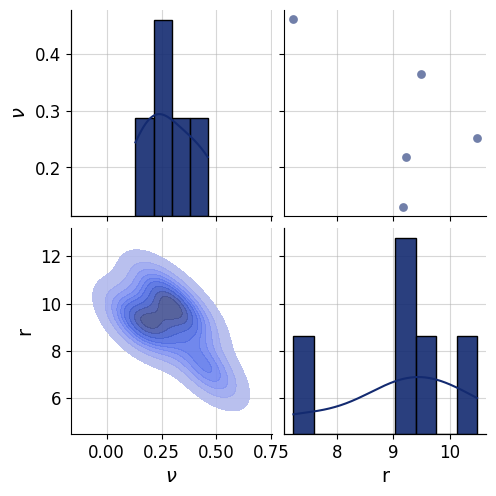

In [43]:
f=bf.diagnostics.pairs_samples(
    df, 
    variable_keys=["nu", "r"],
    variable_names=[r"$\nu$", r"r"])

# Summary Network

In [57]:
adapter = (bf.Adapter()
    .constrain("nu", lower=0.)
    .constrain("r", lower = 0)
    .concatenate(["nu", "r"], into="inference_variables")
    # fixation.shape (batch_size, sentences, max_saccades, 1)
    .concatenate(["time", "fixation", "duration", 'real'], into="summary_variables")
    # summary_variables.shape (batch_size, sentences, max_saccades, 4)
    #.concatenate(['trials'], into='inference_conditions')
    )

In [58]:
class SequentialDeepSet(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.inner = keras.layers.TimeDistributed(
            bf.networks.TimeSeriesNetwork(bidirectional=False, recurrent_dim=64, summary_dim = 8)
        )
        self.outer = bf.networks.DeepSet()
    
    def call(self, x, training=False):
        x = self.inner(x, training=training)
        x = self.outer(x, training=training)
        return x
    
summary_network = SequentialDeepSet()

In [20]:
np.random.normal(size=(256, 20, 40, 4)).shape

(256, 20, 40, 4)

In [59]:
workflow = bf.BasicWorkflow(
    simulator = simulator,
    adapter = adapter,
    summary_network=summary_network,
    
    inference_network = bf.networks.CouplingFlow(permutation="swap", subnet_kwargs=dict(dropout=False)),
    #inference_network = bf.networks.MLP([64, 64]),

    inference_variables = ["nu", "r"],
    #inference_conditions = ["trials"]
)

In [61]:
train_data = simulator.sample(2000)
validation_data = simulator.sample(200)

In [ ]:
history=workflow.fit_offline(
    data=train_data, 
    epochs=100, 
    batch_size=50, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - loss: 8.0066 - loss/inference_loss: 8.0066 - val_loss: 2.6994 - val_loss/inference_loss: 2.6994
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - loss: 2.3684 - loss/inference_loss: 2.3684 - val_loss: 2.2735 - val_loss/inference_loss: 2.2735
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - loss: 1.7626 - loss/inference_loss: 1.7626 - val_loss: 1.2132 - val_loss/inference_loss: 1.2132
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - loss: 1.6497 - loss/inference_loss: 1.6497 - val_loss: 2.1963 - val_loss/inference_loss: 2.1963
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - loss: 1.4126 - loss/inference_loss: 1.4126 - val_loss: 0.8168 - val_loss/inference_loss: 0.8168
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - loss: 1.0662 - loss/inference_loss: 1.0662 - val_loss: 1.8382 - val_loss/inference_loss: 1.8382
Epoch 7/100
 3/40 ━━━━━━━━━━━━━━━━━━━━ 1:13 2s/step - loss: 1.1401 - loss/inference_loss: 1.1401

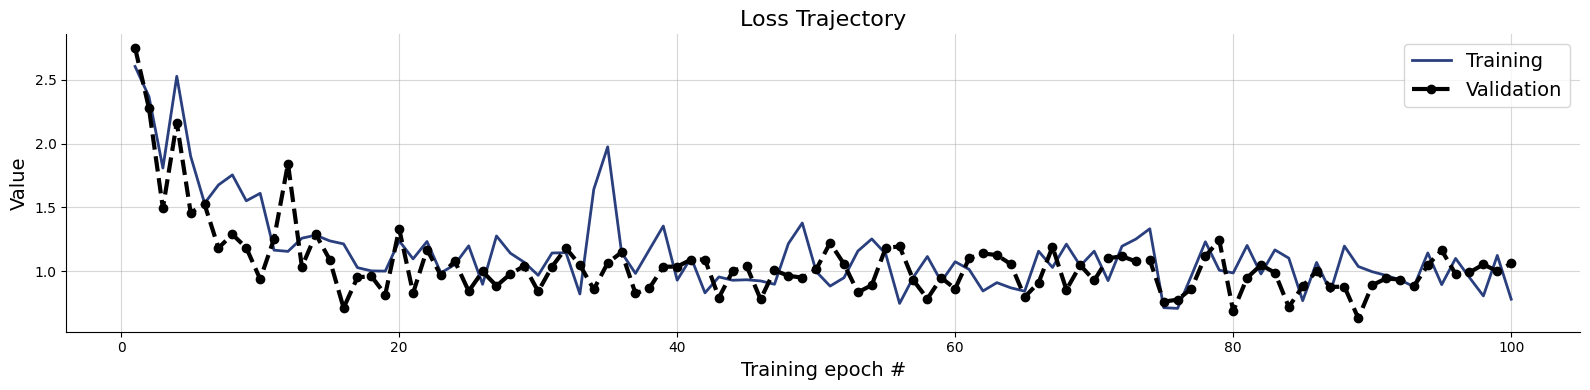

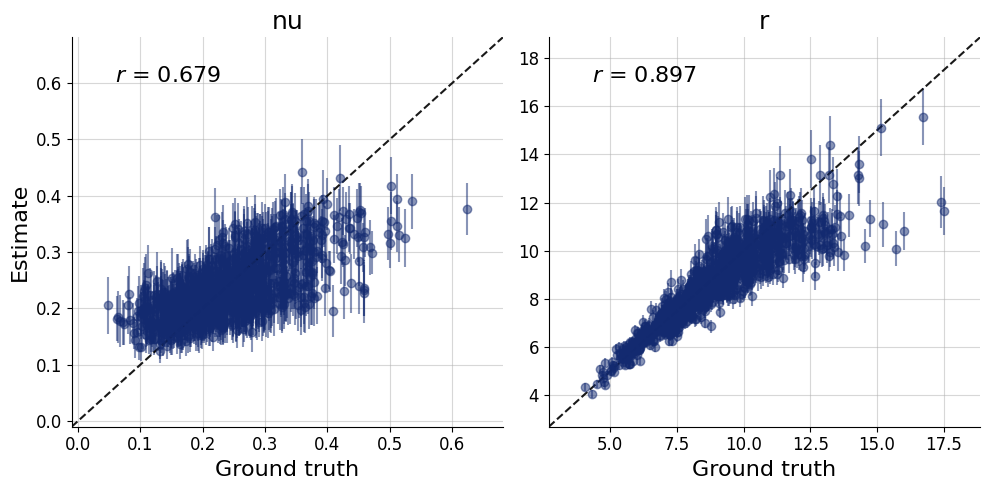

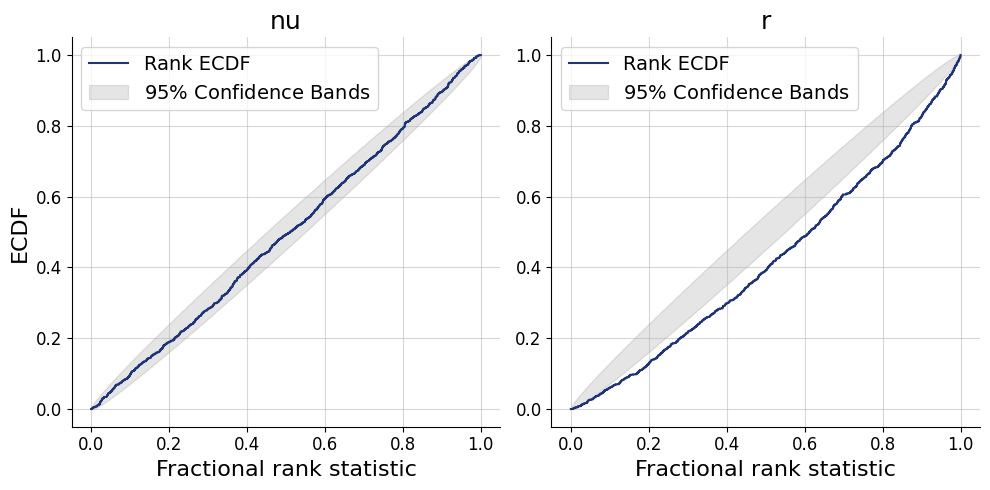

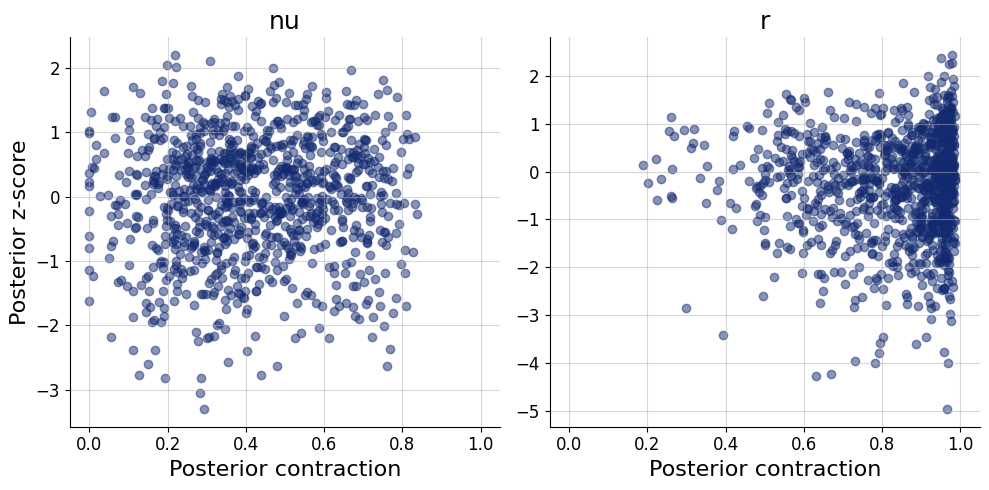

In [55]:
test_data = simulator.sample(1_000)
plots=workflow.plot_default_diagnostics(test_data=test_data)